# 0-背景

两种最普遍的推荐系统的类型是基于内容和协同过滤（CF）。协同过滤基于用户对产品的态度产生推荐，也就是说，它使用“人群的智慧”来推荐产品。与此相反，基于内容的推荐系统集中于物品的属性，并基于它们之间的相似性为你推荐。

一般情况下，协作过滤（CF）是推荐引擎的主力。该算法具有能够自身进行特征学习的一个非常有趣的特性，这意味着它可以开始学习使用哪些特性。CF可以分为基于内存的协同过滤和基于模型的协同过滤。之后我们将使用奇异值分解（SVD）实现基于模型的CF和通过计算余弦相似实现基于内存的CF。

我们将使用MovieLens数据集，它是在实现和测试推荐引擎时所使用的最常见的数据集之一。它包含来自于943个用户以及精选的1682部电影的100K个电影打分。

In [18]:
import numpy as np
import pandas as pd

In [19]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=header)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


In [30]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


使用scikit-learn库将数据集分割成测试和训练。Cross_validation.train_test_split根据测试样本的比例（test_size），本例中是0.25，来将数据混洗并分割成两个数据集。

In [20]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df, test_size=0.25)

# 1-基于内存的协同过滤

基于内存的协同过滤方法可以分为两个主要部分：用户-产品协同过滤和产品-产品协同过滤。一个"用户-产品协同过滤"将选取一个特定的用户，基于打分的相似性发现类似于该用户的用户，并推荐那些相似用户喜欢的产品。相比之下，_产品-产品协同过滤_会选取一个产品，发现喜欢该产品的用户，并找到这些用户或相似的用户还喜欢的其他的产品。输入一个产品，然后输出其他产品作为推荐。

用户-产品协同过滤: “喜欢这个东西的人也喜欢……”
产品-产品协同过滤: “像你一样的人也喜欢……”
在这两种情况下，从整个数据集构建一个用户-产品矩阵。由于你已经将数据拆分到测试集和训练集，那么你将需要创建两个[943 x 1682]矩阵。训练矩阵包含75%的打分，而测试矩阵包含25%的打分。

在构建了用户-产品矩阵后，计算相似性并创建一个相似性矩阵。

在_产品-产品协同过滤_中的产品之间的相似性值是通过观察所有对两个产品之间的打分的用户来度量的。
![](images/1.png)

对于_用户-产品协同过滤_，用户之间的相似性值是通过观察所有同时被两个用户打分的产品来度量的。

通常用于推荐系统中的距离矩阵是_余弦相似性_，其中，打分被看成`n`维空间中的向量，而相似性是基于这些向量之间的角度进行计算的。用户_a_和_m_的余弦相似性可以使用下面的公式进行计算，其中，获取用户向量的点积$u_k$和$u_a$，然后用向量的欧几里得长度的乘积来除以它。
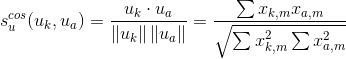

要计算产品_m_和_b_之间的相似性，使用公式：
![image.png](images/1.gif)


第一步是创建用户-产品矩阵。由于你既有测试数据，又有训练数据，那么你需要创建两个矩阵。

In [21]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
#     print(line)
#     print(line[1],line[2],line[3])
#     break
    # line[1]是user_id;line[2]是item_id;line[3]是打分结果
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]
    
#矩阵中每一行是同一个人对各部电影的打分

可以使用sklearn的pairwise_distances函数来计算余弦相似性。注意，输出范围从0到1，因为打分都是正的。

In [22]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [23]:
print(user_similarity.shape)

(943, 943)


下一步是做出预测。你已经创建了相似性矩阵：`user_similarity和item_similarity`，因此，你可以通过为基于用户的CF应用下面的公式做出预测：
![](images/2.gif)

你可以将用户_k_和_a_之间的相似性看成权重，它乘以相似用户_a_ (校正的平均评分用户)的评分。你需要规范化该值，使打分位于1到5之间，最后，对你尝试预测的用户的平均评分求和。

这里的想法是，某些用户可能会倾向于对所有的电影，总是给予高或低评分。这些用户提供的评分的相对差比绝对评分值更重要。举个例子：假设，用户_k_对他最喜欢的电影打4星，而对所有其他的好电影打3星。现在假设另一个用户_t_对他/她喜欢的电影打5星，而对他/她感到无聊的电影打3星。那么这两个用户可能品味非常相似，但对打分系统区别对待。

当为基于产品的CF进行预测时，你无须纠正用户的平均打分，因为查询用户本身就是用来做预测的。
![](images/3.gif)

In [24]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [25]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [31]:
print(item_prediction.shape)
print(user_prediction.shape)

(943, 1682)
(943, 1682)


In [35]:
print(train_data_matrix[1])

[4. 0. 0. ... 0. 0. 0.]


# 2-评估

有许多评价指标，但其中最受欢迎的用来度量预测评分的准确性的指标是_均方根误差 (RMSE)_。
![](images/4.gif)

你可以使用`sklearn`的[`mean_square_error`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE)函数，其中，RMSE仅仅是MSE的平方根。要了解更多不同的评价指标，你可以看看[这篇文章](http://research.microsoft.com/pubs/115396/EvaluationMetrics.TR.pdf)。

由于你只是想要考虑测试数据集中的预测评分，因此，使用`prediction[ground_truth.nonzero()]`筛选出预测矩阵中的所有其他元素。


In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.1223414789236137
Item-based CF RMSE: 3.4502383951612696


基于内存的算法事很容易实现并产生合理的预测质量的。

基于内存的CF的缺点是，它不能扩展到真实世界的场景，并且没有解决众所周知的冷启动问题，也就是当新用户或新产品进入系统时。
基于模型的CF方法是可扩展的，并且可以比基于内存的模型处理更高的稀疏度，但当没有任何评分的用户或产品进入系统时，也是苦不堪言的。

# 3-基于模型的协同过滤

基于模型的协同过滤是基于矩阵分解（MF），它已获得更大的曝光，它主要是作为潜变量分解和降维的一个无监督学习方法。矩阵分解广泛用于推荐系统，其中，它比基于内存的CF可以更好地处理与扩展性和稀疏性. MF的目标是从已知的评分中学习用户的潜在喜好和产品的潜在属性（学习描述评分特征的特征），随后通过用户和产品的潜在特征的点积预测未知的评分。

当你有一个非常稀疏的多维矩阵时，通过进行矩阵分解可以调整用户-产品矩阵为低等级的结构，然后你可以通过两个低秩矩阵（其中，每行包含该本征矢量）的乘积来代表该矩阵。你通过将低秩矩阵相乘，在原始矩阵填补缺少项，以调整这个矩阵，从而尽可能的近似原始矩阵。

让我们计算MovieLens数据集的稀疏度：

In [27]:
sparsity=round(1.0-len(df)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


举例说明用户和产品的学习隐藏偏好：假设MovieLens数据集中有以下信息：_(user id, age, location, gender, movie id, director, actor, language, year, rating)_。通过应用矩阵分解，模型学习到重要的用户特征是年龄组（10岁以下，10-18岁，18-30岁，30-90岁），位置和性别，而对于电影特性，它学习到年份，导演和演员是最重要的。现在，如果你看看你所存储的信息，其中并没有年份这样的特性，但该模型可以自己学习。重要方面是，CF模型仅使用数据（user_id, movie_id, rating）来学习潜在特征。如果只有少数可用的数据，那么基于模型的CF模式将预测不良，因为这将更难以学习潜在特征。

同时使用评分和内容特性的模型称为**混合推荐系统**，其中，协同过滤和基于内容的模型相结合。混合推荐系统通常比协同过滤或基于内容的模型自身表现出更高的精度：它们有能力更好的解决冷启动问题，因为如果你没有一个用户或者一个产品的评分，那么你可以使用该用户或产品的元数据进行预测。混合推荐系统将在未来的教程中介绍。

## 3-1SVD

一个众所周知的矩阵分解方法是**奇异值分解(SVD)**。通过使用奇异值分解，协同过滤可以被近似一个矩阵`X`所制定。Netflix Prize比赛中的获胜队伍使用SVD矩阵分解模型来生成产品建议，更多的信息，推荐阅读文章：[Netflix推荐：5星之外](http://techblog.netflix.com/2012/04/netflix-recommendations-beyond-5-stars.html)和[Netflix Prize和SVD](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf)。

一般的方程可以表示为： 

![](https://latex.codecogs.com/gif.latex?X=USV^T)

给定`m x n`矩阵`X`：
* _`U`_是一个_`(m x r)`_正交矩阵
* _`S`_是一个对角线上为非负实数的_`(r x r)`_对角矩阵
* _V^T_是一个_`(r x n)`_正交矩阵

`S`的对角线上的元素被称为_`X`的奇异值_。

矩阵_`X`_可以被分解成_`U`_，_`S`_和_`V`_。_`U`_矩阵表示对应于隐藏特性空间中的用户的特性矩阵，而_`V`_矩阵表示对应于隐藏特性空间中的产品的特性矩阵现在。可以通过_`U`_, _`S`_和_`V^T`_的点积进行预测了。

In [28]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
# 注意这里是直接在没有打分的位置余弦填充0值了！！！！
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.717792805101509


In [33]:
# 对比下真实值和预测值
print(X_pred.shape)
print(train_data_matrix[0])
print(X_pred[0])

(943, 1682)
[5. 3. 4. ... 0. 0. 0.]
[1.73526400e+00 1.23654759e+00 1.67036579e+00 ... 1.61016282e-04
 0.00000000e+00 0.00000000e+00]


注意，这里使用SVD分解的时候原始的打分数据集在没有打分的位置初始化为0分值。由于这种初始化使得原来的缺失项有了值，可以进行SVD分解操作。但是这种初始化使得结果会有很大的偏差，正如上图预测结果和真实的对比可以看出。另外当打分矩阵很大时候SVD可能会非常缓慢，并且计算成本比较高。更近期的工作通过应用交替最小二乘或随机梯度下降最小化平方误差，并使用正则项以防止过度拟合。

## 3-2 交替最小二乘
交替最小二乘(Alternating Least Squares,ALS)的核心就是这样一个假设：打分矩阵是近似低秩的。
就是一个`m*n`的打分矩阵可以由分解的两个小矩阵$U（m*k）和V（n*k）$的乘积来近似，即 $A=UV^T,k<=m,n $。这就是ALS的矩阵分解方法。
如此系统自由度从$O(mn)$降到了$O((m+n)k)$。

损失函数定义如下：
![](images/ALS_1.png)
分别对用户和item取偏导：
![](images/ALS_2.png)
所以用户u对于项目i的对应k个维度特征为：
![](images/ALS_3.png)
对于项目item的偏导：
![](images/ALS_4.png)

In [39]:
from ExplicitMF_ALS import ExplicitMF
MF_ALS = ExplicitMF(train_data_matrix, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_data_matrix)

In [43]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

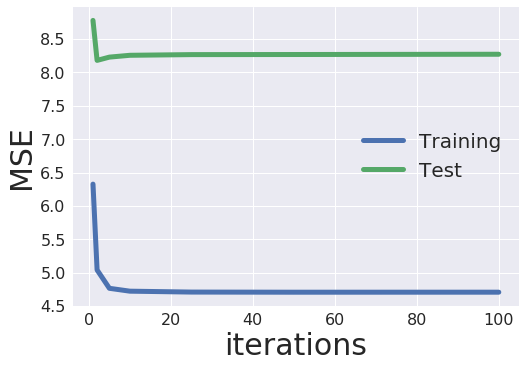

In [44]:
plot_learning_curve(iter_array, MF_ALS)

ALS 模型参数优化。

上述结果Test的MSE比训练集高了50%，过拟合还是比较明显的。测试数据集在迭代5次的时候差不多是到达MSE的最低值，然后开始升高了，进一步带来过拟合了。
我们可以尝试添加正则项来减缓过拟合。

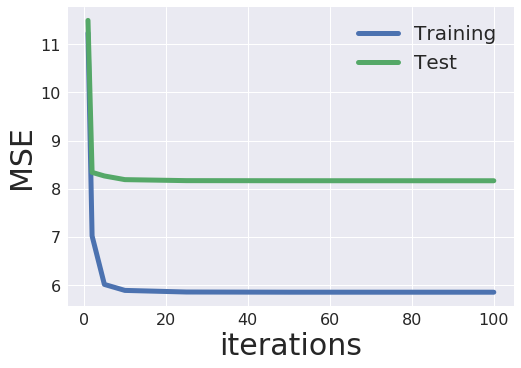

In [48]:
MF_ALS_withre = ExplicitMF(train_data_matrix, n_factors=40, \
                    user_reg=30., item_reg=30.)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS_withre.calculate_learning_curve(iter_array, test_data_matrix)
plot_learning_curve(iter_array, MF_ALS_withre)

从上述结果可以看出测试集和训练集之间MSE差距在缩小,但是下降不是很大。为此，我们可以尝试在正则项和隐含因子数上进行grid search，以获取更优的超参数。

In [49]:
%%time

latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train_data_matrix, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test_data_matrix)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

Factors: 5
Regularization: 0.1
New optimal hyperparameters
model        <ExplicitMF_ALS.ExplicitMF object at 0x7f04913...
n_factors                                                    5
n_iter                                                     100
reg                                                        0.1
test_mse                                                7.5357
train_mse                                              7.16226
dtype: object
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 10
Regularization: 0.1
New optimal hyperparameters
model        <ExplicitMF_ALS.ExplicitMF object at 0x7f04cb6...
n_factors                                                   10
n_iter                                                     100
reg                                                        0.1
test_mse                                               7.15907
train_mse                                              6.42665
dtype: object
Regularization: 1.0
Regularization

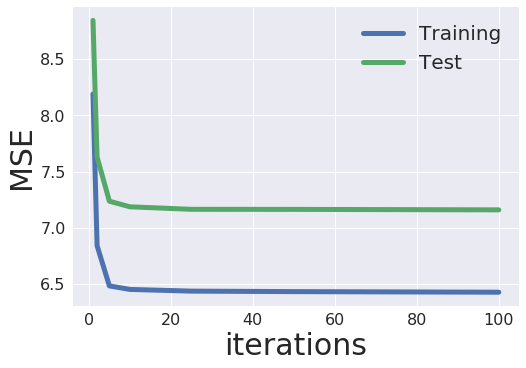

In [50]:
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

从上述接口看，似乎隐含因子数量k=10和正则化值=0.1时，模型MSE值最小。但是有点儿令我不安的是，测试集上的MSE值竟然比训练集低！
接下来，我们尝试使用stochastic gradient descent (SGD)来获取模型的最小代价函数。

## 3-3 SGD

与之前的用户和项目item隐因子的点乘结果作为打分结果不同，SGD是假设每个用户和item都用一个偏移量。其合理性源于可能趋向于对于所有item都打高分或者都打低分。这些偏移项像是信号系统中的直流信号，而隐因子或者隐变量更像是其交流部分。同时也会考虑一个全局的偏移项。为此，预测函数如下：
![](images/SGD_1.png)
损失函数定义如下：
![](images/SGD_2.png)
这里增加了正则项。然后，我们对每个样本处理的时候都更新一次参数。
user bias的更新：
![](images/SGD_3.png)
其中$η$是学习率。$b_u$的偏导结果：
![](images/SGD_4.png)
其中$e_ui$表示预测的错误。这里2倍的系数可以直接去掉，因为可以规整到学习率中。
所有参数的更新如下：
![](images/SGD_5.png)

In [53]:
from ExplicitMF import ExplicitMF

MF_SGD = ExplicitMF(train_data_matrix, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_data_matrix, learning_rate=0.001)

Iteration: 1
Train mse: 1.1585616697673884
Test mse: 1.1807967722408883
Iteration: 2
Train mse: 1.093808318548011
Test mse: 1.1198490752700476
Iteration: 5
Train mse: 0.9952259546736942
Test mse: 1.0285626020977043
Iteration: 10
Train mse: 0.9311315006495025
Test mse: 0.9719311283167997
Iteration: 25
	current iteration: 10
Train mse: 0.8713756748122876
Test mse: 0.924392368309847
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.84006738941939
Test mse: 0.9053770957957386
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7816191246334835
Test mse: 0.8906660145321504
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.44243207686145636
Test mse: 0.8895421389664245


从结果可以看出，SGD的MSE值大大低于之前的方法。

接下来我们进行**SGD的超参数优化：**
<br>
同理这里也是采用grid search方式，先搜索超参数学习率和迭代次数；之后再搜索隐因子k的值和正则项

In [54]:
# grid search 学习率和迭代次数

iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train_data_matrix, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test_data_matrix, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

Rate: 1e-05
New optimal hyperparameters
learning_rate                                               1e-05
model            <ExplicitMF.ExplicitMF object at 0x7f04919c7d30>
n_iter                                                        200
test_mse                                                  1.11982
train_mse                                                 1.09392
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                              0.0001
model            <ExplicitMF.ExplicitMF object at 0x7f04919d7dd8>
n_iter                                                        200
test_mse                                                 0.933288
train_mse                                                0.883666
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                               0.001
model            <ExplicitMF.ExplicitMF object at 0x7f04919d7e80>
n_iter                                                     

In [57]:
print("learning_rate=",best_params['learning_rate'])
print("n_iter=",best_params['n_iter'])
print("train_mse=",best_params['train_mse'])
print("test_mse=",best_params['test_mse'])

learning_rate= 0.001
n_iter= 200
train_mse= 0.444820724256932
test_mse= 0.8778526016303846


从结果看，似乎学习率=0.001，迭代次数=200是最优的。
<br>
接下来我们搜索最优的隐含因子数和正则化。


In [58]:
# grid search 
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train_data_matrix, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test_data_matrix, learning_rate=0.001)#之前学习到的
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

Factors: 5
Regularization: 0.001
New optimal hyperparameters
model        <ExplicitMF.ExplicitMF object at 0x7f049195dc18>
n_factors                                                   5
n_iter                                                    100
reg                                                     0.001
test_mse                                             0.911833
train_mse                                            0.762872
dtype: object
Regularization: 0.01
New optimal hyperparameters
model        <ExplicitMF.ExplicitMF object at 0x7f049195dc50>
n_factors                                                   5
n_iter                                                    100
reg                                                      0.01
test_mse                                             0.905894
train_mse                                            0.769071
dtype: object
Regularization: 0.1
New optimal hyperparameters
model        <ExplicitMF.ExplicitMF object at 0x7f049195dbe0>
n_factor

In [59]:
print("n_factors=",best_params['n_factors'])
print("reg=",best_params['reg'])
print("n_iter=",best_params['n_iter'])

n_factors= 80
reg= 0.01
n_iter= 200


由于n_factors的值和n_iter都是grid search的最大值，所以，我们应该事先设置一个更大范围的search范围。为此我们可以扩大范围后再重新进行grid search。


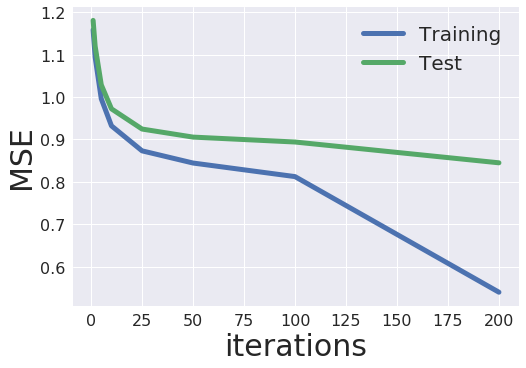

In [60]:
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

## 3-4 ALS和SGD的对比

In [74]:
%%time
best_als_model = ExplicitMF(train_data_matrix, n_factors=10, learning='als', \
                            item_fact_reg=0.1, user_fact_reg=0.1)
best_als_model.train(100)#100次还是200

CPU times: user 2min 38s, sys: 7.35 s, total: 2min 45s
Wall time: 10.4 s


In [63]:
%%time
best_sgd_model = ExplicitMF(train_data_matrix, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01)
best_sgd_model.train(200, learning_rate=0.001)

CPU times: user 5min 45s, sys: 15.1 s, total: 6min 1s
Wall time: 5min 51s


In [76]:
def cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

als_sim = cosine_similarity(best_als_model)
sgd_sim = cosine_similarity(best_sgd_model)

In [66]:
# Load in movie data
# 注意文件的编码，ANSI编码的话，要先转为utf-8
idx_to_movie = {}
with open('../data/ml-100k/u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]

In [69]:
print(len(idx_to_movie))
print(idx_to_movie[0])

1682
http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)


### 3-4-1 结果对比
根据给定的输入，推荐对应的结果，并对比两种模型的推荐结果

In [80]:
def display_top_k_movies(similarity, mapper, movie_idx, k=5):
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]
    images = ''
    k_ctr = 0
    # Start i at 1 to not grab the input movie
    i = 1
    while k_ctr < k:
        movie = mapper[movie_indices[i]]
        k_ctr += 1
        i += 1
        print(movie)

In [82]:
movie_idx = 0
display_top_k_movies(als_sim,idx_to_movie,movie_idx,10)

http://us.imdb.com/Title?Spanish+Prisoner,+The+(1997)
http://us.imdb.com/Title?Object+of+My+Affection,+The+(1998)
http://us.imdb.com/M/title-exact?Witness+(1985)
http://us.imdb.com/M/title-exact?Aiqing%20Wansui%20(1994)
http://us.imdb.com/M/title-exact?Hostile%20Intentions%20(1994)
http://us.imdb.com/M/title-exact?Touki%20Bouki%20(1973)
http://us.imdb.com/Title?Chairman+of+the+Board+(1998)
http://us.imdb.com/M/title-exact?Wend%20Kuuni%20(1982)
http://us.imdb.com/M/title-exact?Tre%20passi%20nel%20delirio%20(1968)
http://us.imdb.com/M/title-exact?imdb-title-118804


In [83]:
# 看看SGD的效果
movie_idx = 0
display_top_k_movies(sgd_sim,idx_to_movie,movie_idx,10)

http://us.imdb.com/M/title-exact?Beauty%20and%20the%20Beast%20(1991)
http://us.imdb.com/M/title-exact?Touch%20(1997)
http://us.imdb.com/M/title-exact?Platoon%20(1986)
http://us.imdb.com/M/title-exact?Ai%20no%20Corrida%20(1976)
http://us.imdb.com/M/title-exact?Funeral,%20The%20(1996)
http://us.imdb.com/M/title-exact?Touch%20of%20Evil%20(1958)
http://us.imdb.com/M/title-exact?Great%20Escape,%20The%20(1963)
http://us.imdb.com/M/title-exact?Aladdin%20(1992)
http://us.imdb.com/M/title-exact?Singin'%20in%20the%20Rain%20(1952)
http://us.imdb.com/M/title-exact?Anaconda%20%281997%29


### 3-4-2 结果分析
单纯从MSE的值可以看出，SGD都是0.4~05，而ALS的MSE差不多在6.5左右，所以SGD的优势明显。
从推荐结果上来看，也似乎SGD的结果更好些。

In [ ]:
def MF_ALS(dir_name):
    print("alternate least squares optimization method...")
    # 数据读取
    train_data, test_data = load_data(dir_name)

    # 填充为原始评分矩阵，训练数据和测试数据
    train_rate = padding_data(list(train_data['user_id']), list(train_data['item_id']), list(train_data['rating']))
    print("train_rate shape=",train_rate.shape)
    # 初始化用户因子矩阵和物品因子矩阵
    user_num = max(list(train_data['user_id']))
    user_matrix = np.random.random((user_num, K))#随机初始化，K值之前已经设置好

    item_num = max(list(train_data['item_id']))
    item_matrix = np.random.random((item_num, K))#随机初始化

    # 开始迭代
    total_valid_loss = []
    for i in range(iteration_times):
        if i % 100 == 0:
            print("iteration times:", i)
        # 使用交替最小二乘法更新user矩阵和物品矩阵
        user_matrix = np.dot(train_rate, np.dot(np.linalg.inv(np.dot(item_matrix.T, item_matrix) + lamb), item_matrix.T).T)
        item_matrix = np.dot(train_rate.T, np.dot(np.linalg.inv(np.dot(user_matrix.T, user_matrix) + lamb), user_matrix.T).T)

        # 计算validation loss
        rate_matrix = np.dot(user_matrix, item_matrix.T)
        valid_loss = loss_function(np.array(test_data['rating']), np.array(rate_matrix[np.array(test_data['user_id'])-1, np.array(test_data['item_id'])-1]), lamb)
        total_valid_loss.append(valid_loss)

    # 绘制validation loss图
    plt_res = plot_result(range(iteration_times), [total_valid_loss], fig_config)
    plt_res.show()

## 3-3 随机梯度下降法的矩阵分解

# 4 CF升级
用于CF的交替最小二乘和随机梯度下降的方法将在未来的教程中介绍。

总结一下：

- 在这篇文章中，我们讲了如何实现简单的协同过滤方法，包括基于内存的CF和基于模型的CF。
- 基于内存的模型是基于产品或用户之间的相似性，其中，我们使用余弦相似性。
- 基于模型的CF是基于矩阵分解，其中，我们使用SVD来分解矩阵。
- 构建在冷启动的情况下（其中，对于新用户和新产品来说，数据不可用）表现良好的推荐系统仍然是一个挑战。标准的协同过滤方法在这样的设置下表现不佳。在接下来的教程中，你将深入研究这一问题。

https://github.com/ictar/python-doc/blob/master/Science%20and%20Data%20Analysis/%E5%9C%A8Python%E4%B8%AD%E5%AE%9E%E7%8E%B0%E4%BD%A0%E8%87%AA%E5%B7%B1%E7%9A%84%E6%8E%A8%E8%8D%90%E7%B3%BB%E7%BB%9F.md